In [1]:
import scanpy
import pandas as pd
import numpy as np
from collections import OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
cosinemap = sns.diverging_palette(220, 20, as_cmap=True)

In [3]:
tissues = ['WT', 'HFD', 'OB/OB']
usamples = ["WT", "OB/OB", "WT", "HFD"]
lut = {usamples[i]: plt.get_cmap("tab10")(i) for i in range(4)}

## Compare reps

In [4]:
import scanpy
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.metrics import silhouette_score

In [5]:
adata_beta = scanpy.read_h5ad('../data/beta_run_2.h5ad')

In [6]:
markers = pd.read_csv('../data/dotplot_presentation_beta_cell_markers', dtype=str, header=None)
markers.columns = ['group', 'gene']

In [7]:
names = adata_beta.var['names']
samples = ['WT', 'HFD', 'OB_OB']
num_ats = [7, 4, 3]
all_genes = pd.DataFrame(columns=names)
for i,sample in enumerate(samples):
    tissue_ats = np.load(f'results/{sample}_data_{num_ats[i]}_ats.npy')
    for j in range(num_ats[i]):
        all_genes.loc[f'{sample}_AT{j+1}'] = tissue_ats[j,:]

In [8]:
similarities = cosine_similarity(all_genes)
sim = pd.DataFrame(similarities, index=all_genes.index, columns=all_genes.index)

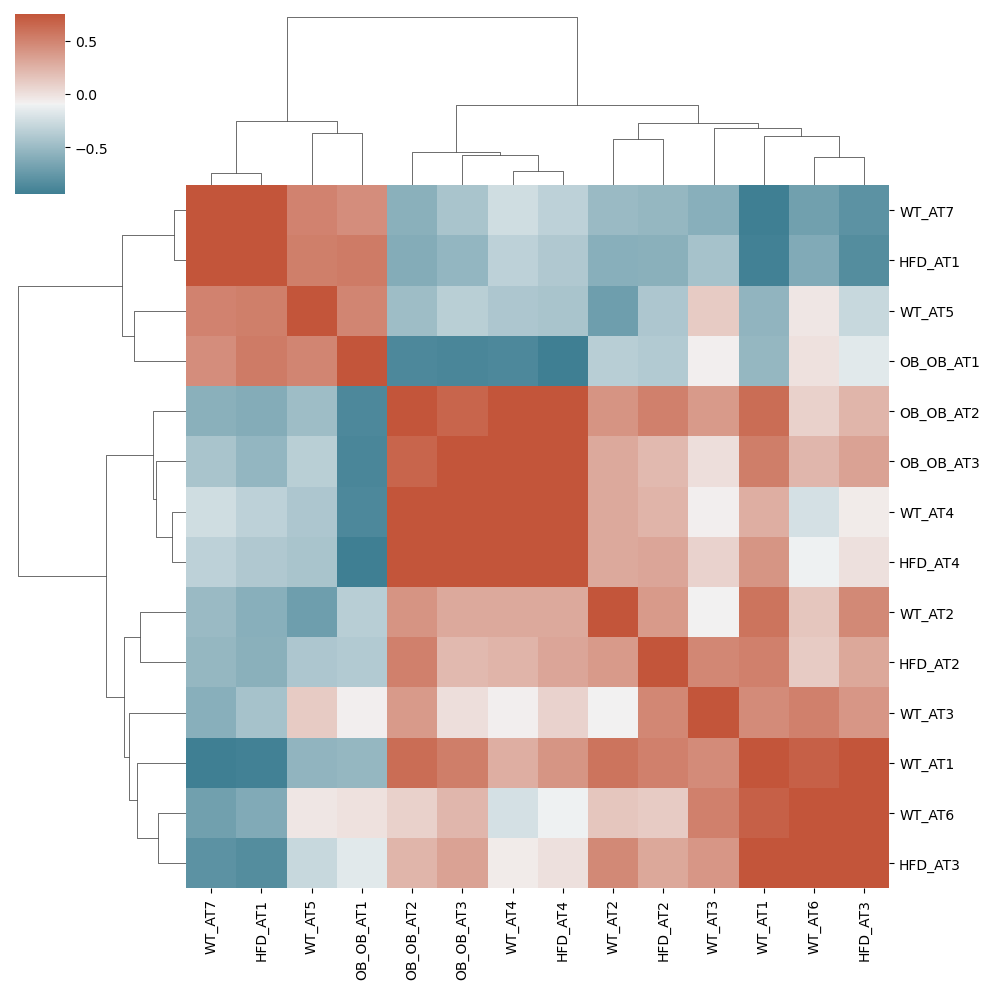

In [9]:
from scipy.spatial import distance
from scipy.cluster import hierarchy

correlations_array = sim.values

d=distance.pdist(correlations_array)
row_linkage = hierarchy.linkage(d, method='average')
clusters = hierarchy.fcluster(row_linkage, 0.35*d.max(), 'distance')

fig = sns.clustermap(sim, row_linkage=row_linkage, col_linkage=row_linkage, cmap=cosinemap, vmax=0.75)

In [10]:
fig.savefig('figures/cosine_similarity_across_ATs_WT4.png', format='png', dpi=200)

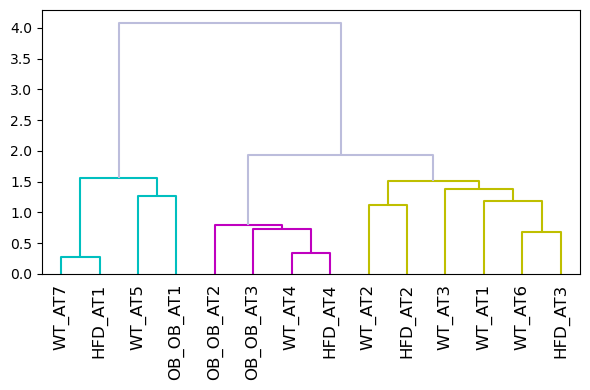

In [21]:
threshold = 1.6
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
hierarchy.set_link_color_palette(['c', 'm', 'y', 'k'])
dn = hierarchy.dendrogram(row_linkage, ax=ax, color_threshold=threshold,
                          labels=all_genes.index, leaf_rotation=90,
                          above_threshold_color='#bcbddc')
plt.tight_layout()
fig.savefig('figures/AT_clustering_threshold_1_6.png', dpi=300)

### Proportions per archetypal cluster (without uncommitted cells)

In [12]:
groups = [['WT AT 7', 'HFD AT 1', 'WT AT 5', 'OB/OB AT 1'],
          ['OB/OB AT 2', 'OB/OB AT 3', 'WT AT 4', 'HFD AT 4'],
          ['WT AT 2', 'HFD AT 2', 'WT AT 3', 'WT AT 1', 'WT AT 6', 'HFD AT 3']]

In [13]:
proportions_per_AT_cluster = []
count_without_uncommitted_cells = adata_beta[~adata_beta.obs['AT_committment'].isin(['Uncommitted'])].obs.groupby('samples').count()['AT_committment']
for group in groups:
    props = (adata_beta[adata_beta.obs['AT_committment'].isin(group)].obs.groupby('samples').count()['AT_committment'] / count_without_uncommitted_cells)
    proportions_per_AT_cluster.append(props)

In [14]:
proportions_per_AT_cluster = pd.DataFrame(proportions_per_AT_cluster)
proportions_per_AT_cluster = proportions_per_AT_cluster[['WT', 'HFD', 'OB/OB']]

In [15]:
colors = list(sns.color_palette('Set1', n_colors=4)) + \
list(sns.color_palette('Paired', n_colors=3)) + ['lightgray'] + \
list(sns.color_palette('Set2', n_colors=7).as_hex())
colors = dict(zip(sorted(proportions_per_AT_cluster.columns), colors))

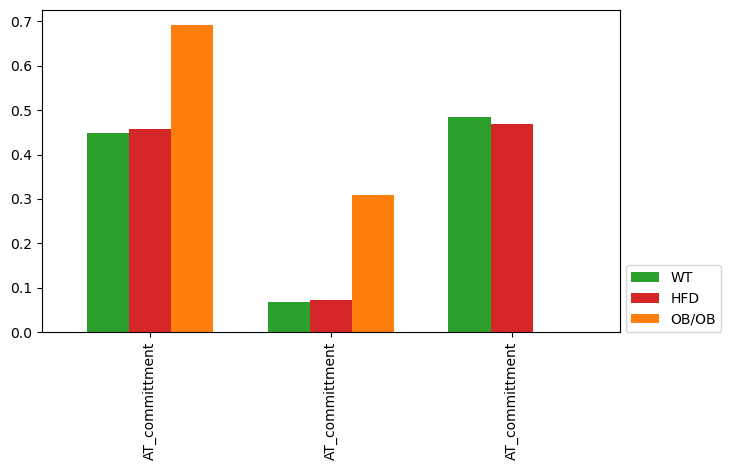

In [16]:
fig, ax = plt.subplots()
proportions_per_AT_cluster.plot(kind='bar', ax=ax, color=lut, width=0.7)
plt.tight_layout()
plt.legend(loc=(1.01,0))
fig.savefig('figures/proportions_per_AT_cluster_without_uncommitted.png')

In [17]:
proportions_per_AT_cluster.index = range(1,len(groups)+1)

In [18]:
proportions_per_AT_cluster

samples,WT,HFD,OB/OB
1,0.448138,0.457696,0.691159
2,0.067281,0.073055,0.308841
3,0.484581,0.469249,NaN
